# Preparation of E_data

This notebook, takes the ipfx features and e-phys time series and prepares the ephys input data for Cpl_AE_TE model. 

In [1]:
import csv
import h5py
import feather
import numpy as np
import pandas as pd
import seaborn as sns
from functools import reduce
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import cplAE_MET.utils.preproc_helpers as proc_utils
%matplotlib inline

def set_raw_data_paths():
    pth={}
    pth['base_path'] = "/Users/fahimehb/Documents/git-workspace/coupledAE-patchseq/data/proc/" 
    pth['E_timeseries'] = pth['base_path'] + 'inh_fv_Ephys_run_all_2July2021.h5'
    pth['ipfx'] = pth['base_path'] + 'inh_ipfx_features_2July2021.csv'
    return pth

## Time series

All time series data were extracted and are saved in the following file:

In [2]:
#Time series
pth = set_raw_data_paths()
E_timeseries = pth['E_timeseries']
hf = h5py.File(E_timeseries, 'r')

Different experiments are the following:

In [3]:
print(len(hf.keys()))
hf.keys()

14


<KeysViewHDF5 ['first_ap_dv', 'first_ap_v', 'ids', 'inst_freq', 'isi_shape', 'psth', 'spiking_fast_trough_v', 'spiking_peak_v', 'spiking_threshold_v', 'spiking_upstroke_downstroke_ratio', 'spiking_width', 'step_subthresh', 'subthresh_depol_norm', 'subthresh_norm']>

In total, 1599 cells have time series data available:

In [4]:
h5_ids = np.array(hf.get("ids"))
print(len(h5_ids))

3793


In [5]:
time_series = {}
for k in hf.keys():
    time_series[k] = np.array(hf.get(k))

In [6]:
time_series.keys()

dict_keys(['first_ap_dv', 'first_ap_v', 'ids', 'inst_freq', 'isi_shape', 'psth', 'spiking_fast_trough_v', 'spiking_peak_v', 'spiking_threshold_v', 'spiking_upstroke_downstroke_ratio', 'spiking_width', 'step_subthresh', 'subthresh_depol_norm', 'subthresh_norm'])

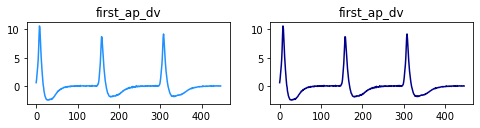

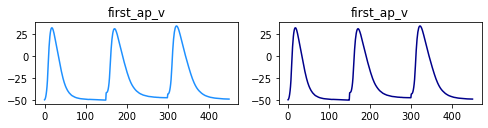

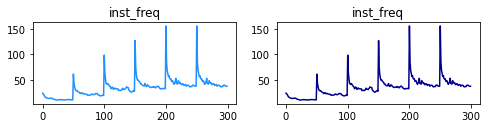

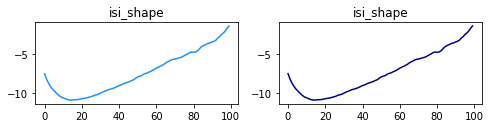

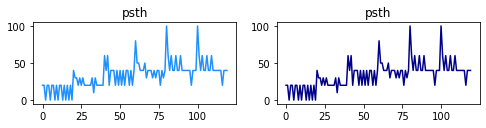

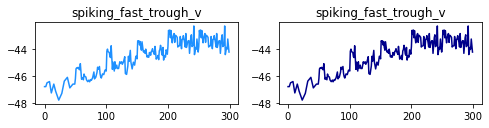

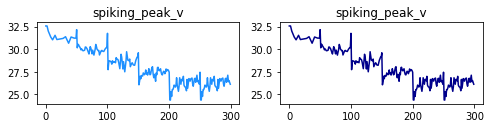

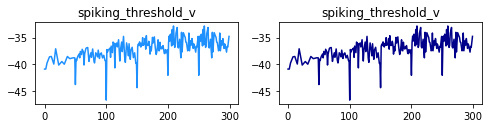

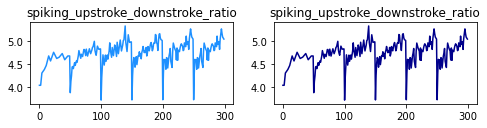

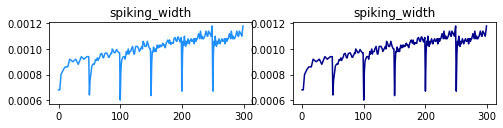

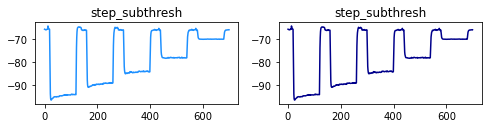

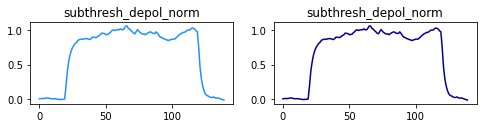

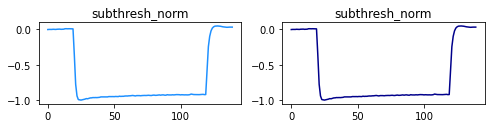

In [7]:
cellid = 1000
for sub_expt in time_series.keys():
    if sub_expt != "ids":
        plt.figure(figsize=(8,1.5))
        plt.subplot(1,2,1)
        plt.plot(time_series[sub_expt][cellid,:],color='dodgerblue')
        plt.title(sub_expt)
    
        plt.subplot(1,2,2)
        plt.plot(time_series[sub_expt][cellid,:],color='darkblue')
        plt.title(sub_expt)
        plt.show()

# Applying PCA

We would like to apply PCA on the time series. Only in one of the experiments (`subthresh_depol_norm` ), there are some nan values in the data. To apply PCA, these rows should be dropped. 

In [8]:
# Check if there is any nan values in any of the np arrays
expt_with_nans = []
for sub_expt in time_series.keys():
    if sub_expt != "ids":
        if proc_utils.check_for_nan(time_series[sub_expt]):
            print("nan values were detected in this experiment:", sub_expt)
            expt_with_nans.append(sub_expt)

nan values were detected in this experiment: subthresh_depol_norm


In [9]:
# Remove nan values from the timeseries with nan
dropped_cells = {}
for sub_expt in expt_with_nans:
    time_series[sub_expt], dropped_cells[sub_expt] = proc_utils.drop_nan_rows_or_cols(time_series[sub_expt], 1)

We compute number of components that can explain more than 97% of the variance in the data:

first_ap_dv


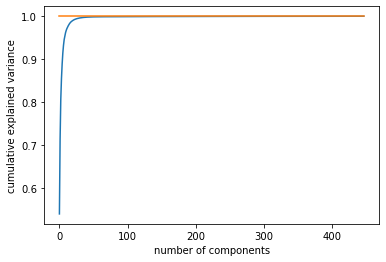

first_ap_v


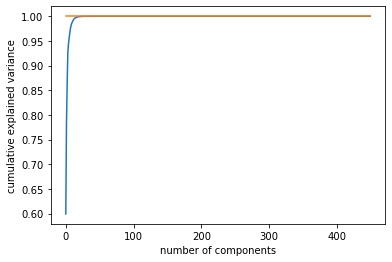

inst_freq


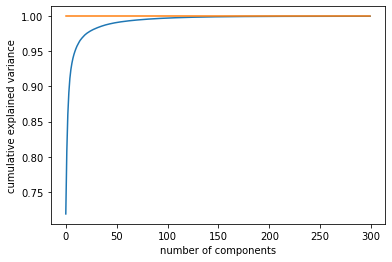

isi_shape


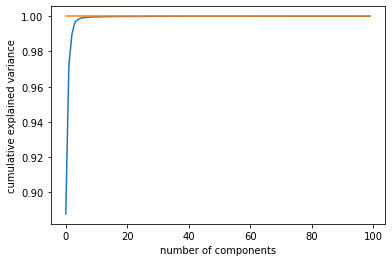

psth


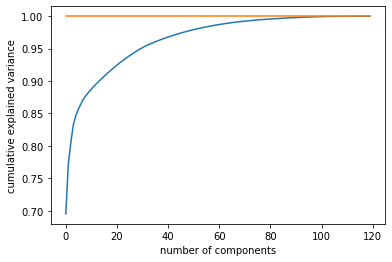

spiking_fast_trough_v


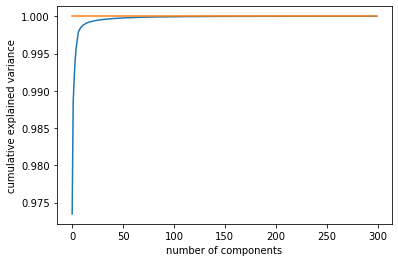

spiking_peak_v


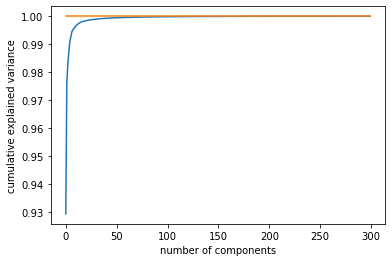

spiking_threshold_v


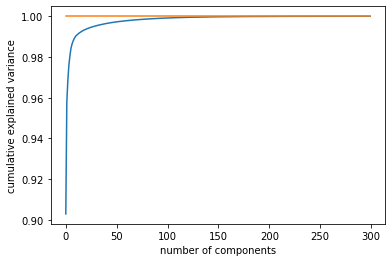

spiking_upstroke_downstroke_ratio


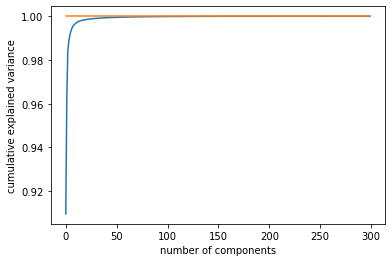

spiking_width


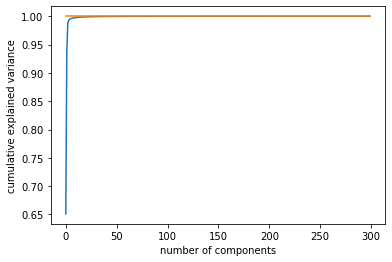

step_subthresh


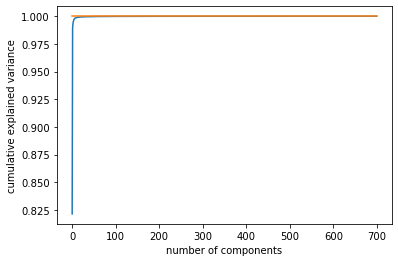

subthresh_depol_norm


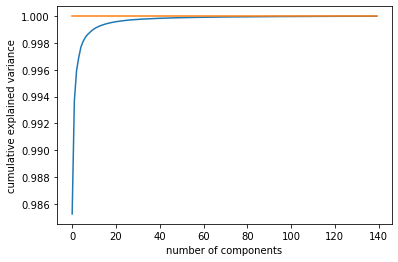

subthresh_norm


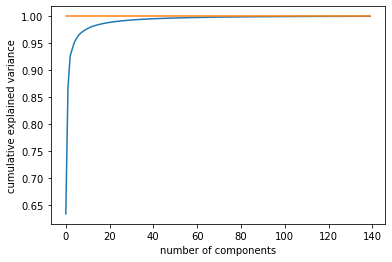

In [10]:
number_of_components = {}
for k in hf.keys():
    if k not in ["ids"]:
        print(k)
        n_comp_at_thr = proc_utils.get_PCA_explained_variance_ratio_at_thr(
            nparray=time_series[k], threshold=0.97)
        #If number of components are zero, then use 1
        if n_comp_at_thr == 0:
            number_of_components[k] = 1
        else:
            number_of_components[k] = n_comp_at_thr

How many features in each experiment is required to explain at least 97% of the variance in the data?

In [11]:
number_of_components

{'first_ap_dv': 11,
 'first_ap_v': 7,
 'inst_freq': 17,
 'isi_shape': 1,
 'psth': 42,
 'spiking_fast_trough_v': 1,
 'spiking_peak_v': 1,
 'spiking_threshold_v': 3,
 'spiking_upstroke_downstroke_ratio': 2,
 'spiking_width': 2,
 'step_subthresh': 1,
 'subthresh_depol_norm': 1,
 'subthresh_norm': 8}

We apply PCA and for each experiment keep the above-mentioned components:

In [12]:
PC = {}

for k in hf.keys():
    if k != "ids":
        pca = PCA(number_of_components[k])
        PC[k] = pca.fit_transform(time_series[k])
        print(k, PC[k].shape)

first_ap_dv (3793, 11)
first_ap_v (3793, 7)
inst_freq (3793, 17)
isi_shape (3793, 1)
psth (3793, 42)
spiking_fast_trough_v (3793, 1)
spiking_peak_v (3793, 1)
spiking_threshold_v (3793, 3)
spiking_upstroke_downstroke_ratio (3793, 2)
spiking_width (3793, 2)
step_subthresh (3793, 1)
subthresh_depol_norm (3342, 1)
subthresh_norm (3793, 8)


# Scaling PC features

In [14]:
Scaled_PCs = {}
total_var = {}

for k in PC.keys():
    total_var[k] = np.sqrt(np.sum(pd.DataFrame(PC[k]).var(axis=0)))
    Scaled_PCs[k] = PC[k] / total_var[k]
    if (proc_utils.check_for_nan(Scaled_PCs[k])):
        Scaled_PCs[k], _ = proc_utils.drop_nan_rows_or_cols(Scaled_PCs[k], axis=1)
    print(k, Scaled_PCs[k].shape)

first_ap_dv (3793, 11)
first_ap_v (3793, 7)
inst_freq (3793, 17)
isi_shape (3793, 1)
psth (3793, 42)
spiking_fast_trough_v (3793, 1)
spiking_peak_v (3793, 1)
spiking_threshold_v (3793, 3)
spiking_upstroke_downstroke_ratio (3793, 2)
spiking_width (3793, 2)
step_subthresh (3793, 1)
subthresh_depol_norm (3342, 1)
subthresh_norm (3793, 8)


In [15]:
#attaching specimen ids
for k in PC.keys():
    Scaled_PCs[k] = pd.DataFrame(Scaled_PCs[k])
    scaling_thr = np.abs(np.max(Scaled_PCs[k].std(axis=0, skipna=True, numeric_only=True)) * 6)
    Scaled_PCs[k] = Scaled_PCs[k][(Scaled_PCs[k] < scaling_thr) & (Scaled_PCs[k] > -1 * scaling_thr)]
    Scaled_PCs[k].columns = [k + "_" + str(i) for i in range(Scaled_PCs[k].shape[1])] 
    if k not in dropped_cells.keys():
        Scaled_PCs[k]["specimen_id"] = h5_ids
    else:
        Scaled_PCs[k]["specimen_id"] = np.delete(h5_ids, obj=dropped_cells[k])
        
    Scaled_PCs[k]['specimen_id'] = Scaled_PCs[k]['specimen_id'].astype(str)


In [16]:
Scaled_PCs[k]

,subthresh_norm_0,subthresh_norm_1,subthresh_norm_2,subthresh_norm_3,subthresh_norm_4,subthresh_norm_5,subthresh_norm_6,subthresh_norm_7,specimen_id
0,0.375863,-0.239552,-0.318704,-0.009621,0.038915,-0.004154,-0.025462,-0.030652,888001481
1,-0.790717,-0.189610,-0.097242,-0.096582,0.083177,0.041483,-0.026525,0.004687,888088377
2,0.156272,-0.340598,-0.166892,-0.051455,0.083612,0.002428,-0.096801,-0.024198,854425428
3,1.914338,-0.398724,0.018655,-0.013506,0.051352,-0.110071,-0.024431,-0.041972,700278065
4,0.337164,-0.600193,0.012799,0.042350,-0.031959,0.014269,0.000194,-0.021220,651167896
...,...,...,...,...,...,...,...,...,...
3788,-0.425725,-0.590973,-0.088613,0.045499,-0.005569,-0.065211,0.020300,-0.009229,1003321825
3789,-0.641967,-0.096056,0.226359,0.070833,-0.026811,-0.026552,-0.016912,0.009130,809105260
3790,-0.407457,-0.459114,-0.178438,0.044369,-0.047480,-0.026018,-0.035662,0.023150,992271641
3791,-0.302146,-0.539299,-0.012064,0.027773,-0.069693,0.008342,0.012880,-0.022578,698509705


In [17]:
Scaled_PCs[k].head()

,subthresh_norm_0,subthresh_norm_1,subthresh_norm_2,subthresh_norm_3,subthresh_norm_4,subthresh_norm_5,subthresh_norm_6,subthresh_norm_7,specimen_id
0,0.375863,-0.239552,-0.318704,-0.009621,0.038915,-0.004154,-0.025462,-0.030652,888001481
1,-0.790717,-0.189610,-0.097242,-0.096582,0.083177,0.041483,-0.026525,0.004687,888088377
2,0.156272,-0.340598,-0.166892,-0.051455,0.083612,0.002428,-0.096801,-0.024198,854425428
3,1.914338,-0.398724,0.018655,-0.013506,0.051352,-0.110071,-0.024431,-0.041972,700278065
4,0.337164,-0.600193,0.012799,0.042350,-0.031959,0.014269,0.000194,-0.021220,651167896


In [18]:
data_frames = []
for k in Scaled_PCs.keys():
    data_frames.append(Scaled_PCs[k])
    
Scaled_PCs = reduce(lambda  left,right: pd.merge(left,right,on=['specimen_id'], how='outer'), data_frames)

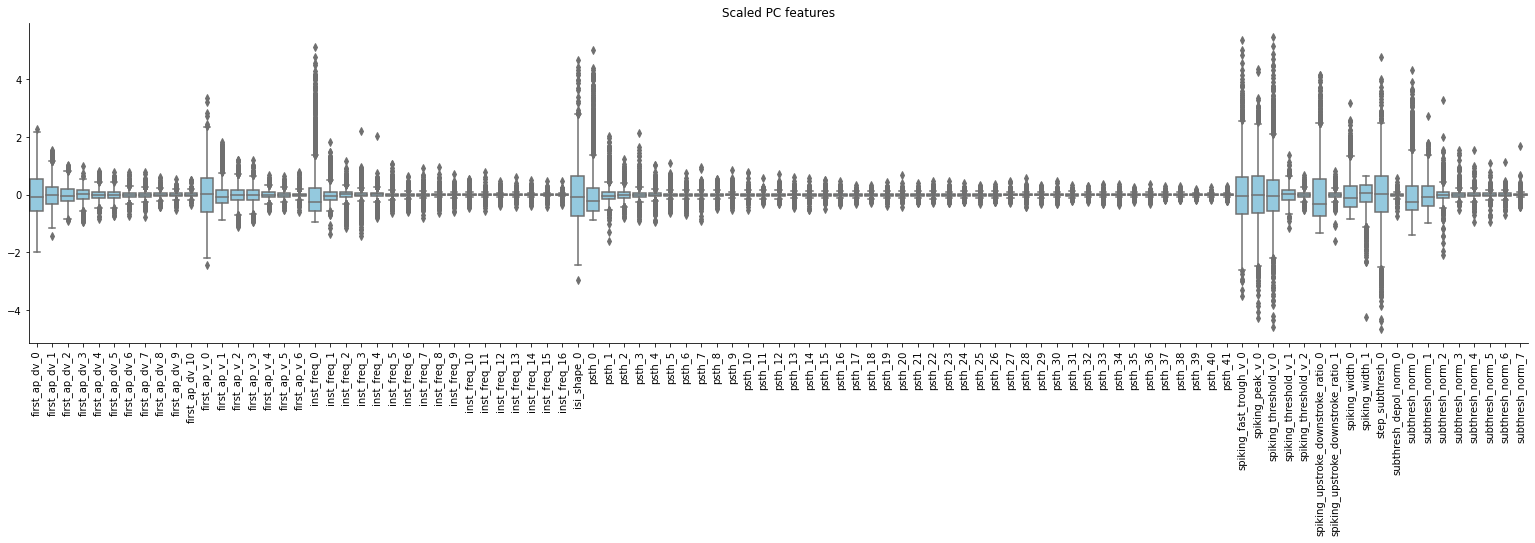

In [19]:
df = Scaled_PCs.melt(value_vars=Scaled_PCs[[c for c in Scaled_PCs.columns if c != "specimen_id"]])
sns.catplot(x="variable", y="value",kind='box', data=df, palette=sns.color_palette(["skyblue"]),aspect=4.4)
ax = plt.gca()
ax.set(**{'title':'Scaled PC features','xlabel':'','ylabel':''})
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

# ipfx features

In [20]:
ipfx = pd.read_csv("/Users/fahimehb/Documents/git-workspace/coupledAE-patchseq/data/proc/inh_ipfx_features_2July2021.csv")
print(ipfx.shape)
ipfx.head()

(3803, 151)


,specimen_id,ap_1_threshold_v_ramp,ap_1_peak_v_ramp,ap_1_upstroke_ramp,ap_1_downstroke_ramp,ap_1_upstroke_downstroke_ratio_ramp,ap_1_width_ramp,ap_1_fast_trough_v_ramp,ap_1_threshold_v_short_square,ap_1_peak_v_short_square,...,ap_mean_upstroke_downstroke_ratio_5_long_square,ap_mean_width_5_long_square,ap_mean_fast_trough_v_5_long_square,first_isi_5_long_square,avg_rate_5_long_square,isi_cv_5_long_square,latency_5_long_square,median_isi_5_long_square,adapt_5_long_square,stimulus_amplitude_5_long_square
0,888001481,-32.900002,15.256251,128.710898,-40.671471,3.165069,0.001527,-47.012501,-33.128124,4.300000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,888088377,-28.641668,0.604167,70.397091,-15.565032,4.530773,0.002400,-41.164584,-19.203125,-0.775000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,854425428,-28.345835,37.772915,226.678731,-59.298707,3.826954,0.001247,-45.687500,-33.787498,35.140625,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,700278065,-39.593754,20.312502,186.264709,-48.749376,3.820863,0.001300,-55.500004,-44.859375,16.382814,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,651167896,-30.625000,15.156250,125.468635,-46.048457,2.724709,0.001180,-42.062504,-40.125000,22.953125,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
keep_ipfx_features_bioarxiv = ['ap_1_threshold_v_short_square', 'ap_1_peak_v_short_square',
       'ap_1_upstroke_short_square', 'ap_1_downstroke_short_square',
       'ap_1_upstroke_downstroke_ratio_short_square',
       'ap_1_width_short_square', 'ap_1_fast_trough_v_short_square',
       'short_square_current', 'input_resistance', 'tau', 'v_baseline',
       'sag_nearest_minus_100', 'sag_measured_at', 'rheobase_i',
       'ap_1_threshold_v_0_long_square', 'ap_1_peak_v_0_long_square',
       'ap_1_upstroke_0_long_square', 'ap_1_downstroke_0_long_square',
       'ap_1_upstroke_downstroke_ratio_0_long_square',
       'ap_1_width_0_long_square', 'ap_1_fast_trough_v_0_long_square',
       'avg_rate_0_long_square', 'latency_0_long_square',
       'stimulus_amplitude_0_long_square', "specimen_id"]

In [22]:
ipfx = ipfx[keep_ipfx_features_bioarxiv]

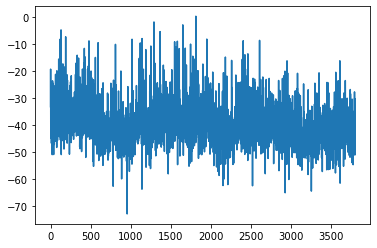

In [23]:
plt.plot(ipfx["ap_1_threshold_v_short_square"])

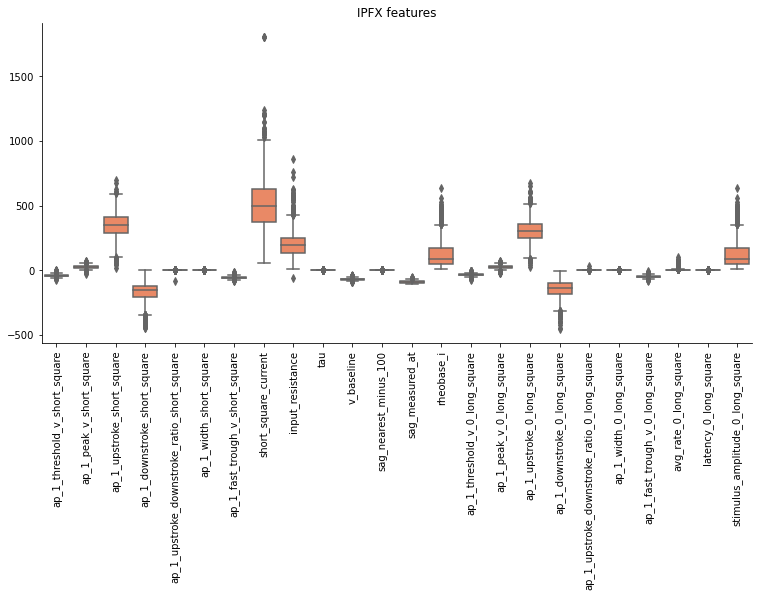

In [24]:
df = ipfx.melt(value_vars=ipfx[[c for c in ipfx.columns if c != "specimen_id"]])
sns.catplot(x="variable", y="value",kind='box', data=df, palette=sns.color_palette(["coral"]),aspect=2.4)
ax = plt.gca()
ax.set(**{'title':'IPFX features','xlabel':'','ylabel':''})
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

In [25]:
subset_ipfx = ipfx[[c for c in ipfx.columns if c != "specimen_id"]]
ipfx_norm = (subset_ipfx - subset_ipfx.mean(axis=0)) / subset_ipfx.std(axis=0)

In [26]:
scaling_thr = ipfx_norm.std(axis=0, skipna=True, numeric_only=True) * 6 
ipfx_norm = ipfx_norm.reset_index()
df1 = pd.melt(ipfx_norm, id_vars=['index'], value_vars=[c for c in ipfx_norm if c != "index"])
df2 = pd.DataFrame(scaling_thr).reset_index().rename(columns={"index": 'variable', 0:"thr_std"})
df3 = df1.merge(df2, on="variable")
df3['new_value'] = np.where((df3['value'] < df3['thr_std']) & (df3['value'] > -1 * df3['thr_std'])
                     , df3['value'], np.nan)
ipfx_norm = df3.pivot(index='index', columns="variable", values="new_value")
ipfx_norm['specimen_id'] = ipfx['specimen_id'].astype(str)

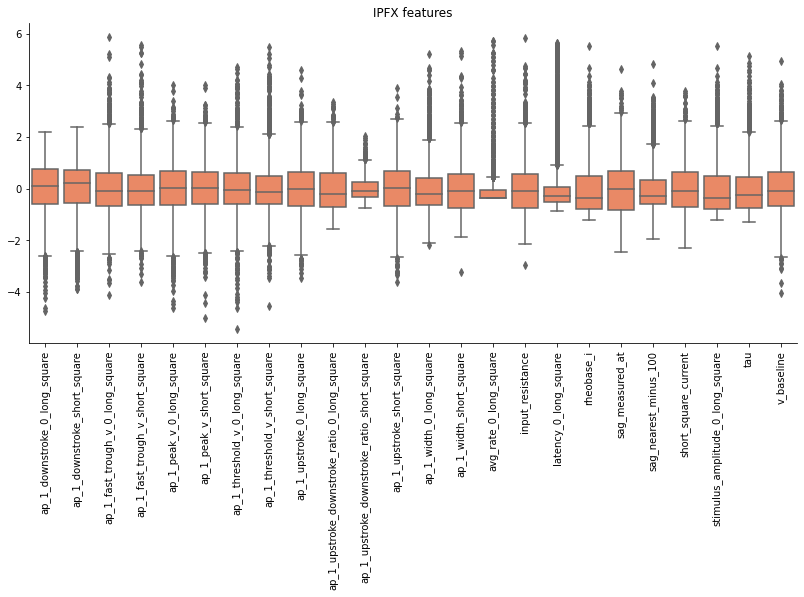

In [27]:
df = ipfx_norm.melt(value_vars=ipfx_norm[[c for c in ipfx_norm.columns if c != "specimen_id"]])
sns.catplot(x="variable", y="value",kind='box', data=df, palette=sns.color_palette(["coral"]),aspect=2.4)
ax = plt.gca()
ax.set(**{'title':'IPFX features','xlabel':'','ylabel':''})
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

# Putting all together

In [30]:
data_frames = [Scaled_PCs, ipfx_norm]    
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['specimen_id'], how='outer'), data_frames)

In [31]:
annotation = annotation.rename({"spec_id_label":"specimen_id"}, axis="columns")
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['specimen_id'], how='inner'), [annotation[["specimen_id", "sample_id"]], df_merged])
df_merged = df_merged.drop(labels=["specimen_id"], axis=1)

NameError: name 'annotation' is not defined

In [32]:
df_merged.to_csv("/Users/fahimehb/Documents/git-workspace/coupledAE-patchseq/data/proc/inh_Merged_Ephys_features.csv")

In [85]:
df_merged.head()

,sample_id,first_ap_dv_0,first_ap_dv_1,first_ap_dv_2,first_ap_dv_3,first_ap_dv_4,first_ap_dv_5,first_ap_dv_6,first_ap_dv_7,first_ap_dv_8,...,avg_rate_0_long_square,input_resistance,latency_0_long_square,rheobase_i,sag_measured_at,sag_nearest_minus_100,short_square_current,stimulus_amplitude_0_long_square,tau,v_baseline
0,P1S4_190617_001_A01,-0.919756,0.700900,-0.237131,0.196895,-0.065753,0.131430,-0.098393,-0.088334,-0.049728,...,-0.355280,0.410741,-0.311039,-0.346733,-0.806872,0.369393,-0.295386,-0.346733,-0.234058,-0.137481
1,P2S4_180813_052_A01,-0.475642,0.238063,-0.083658,0.042742,-0.221290,0.042716,0.078785,0.036728,0.012847,...,1.249007,0.003561,-0.594176,0.402432,0.782729,0.963700,-0.140041,0.402432,-0.589063,0.052466
2,P9S4_171024_408_A01,-0.988633,0.299940,0.258093,-0.170383,0.222431,-0.008273,0.034644,0.156483,-0.020396,...,-0.355280,-0.944802,-0.520634,1.354942,1.753238,0.781863,0.740249,1.354942,-0.895508,0.750791
3,PAS4_180123_452_A01,-0.076746,-0.131319,-0.058069,-0.123293,-0.366513,0.280751,0.242099,0.188966,0.067651,...,1.730293,-0.635937,-0.497126,1.247918,0.459725,1.956468,0.377777,1.247918,-0.886903,0.207751
4,PAS4_190513_452_A01,-0.304653,-0.181313,-0.149711,0.004489,-0.080304,0.061383,-0.109638,-0.056269,0.097680,...,-0.355280,-0.493712,-0.417806,-0.239710,-0.757523,1.827259,0.170650,-0.239710,-0.598469,-1.167281


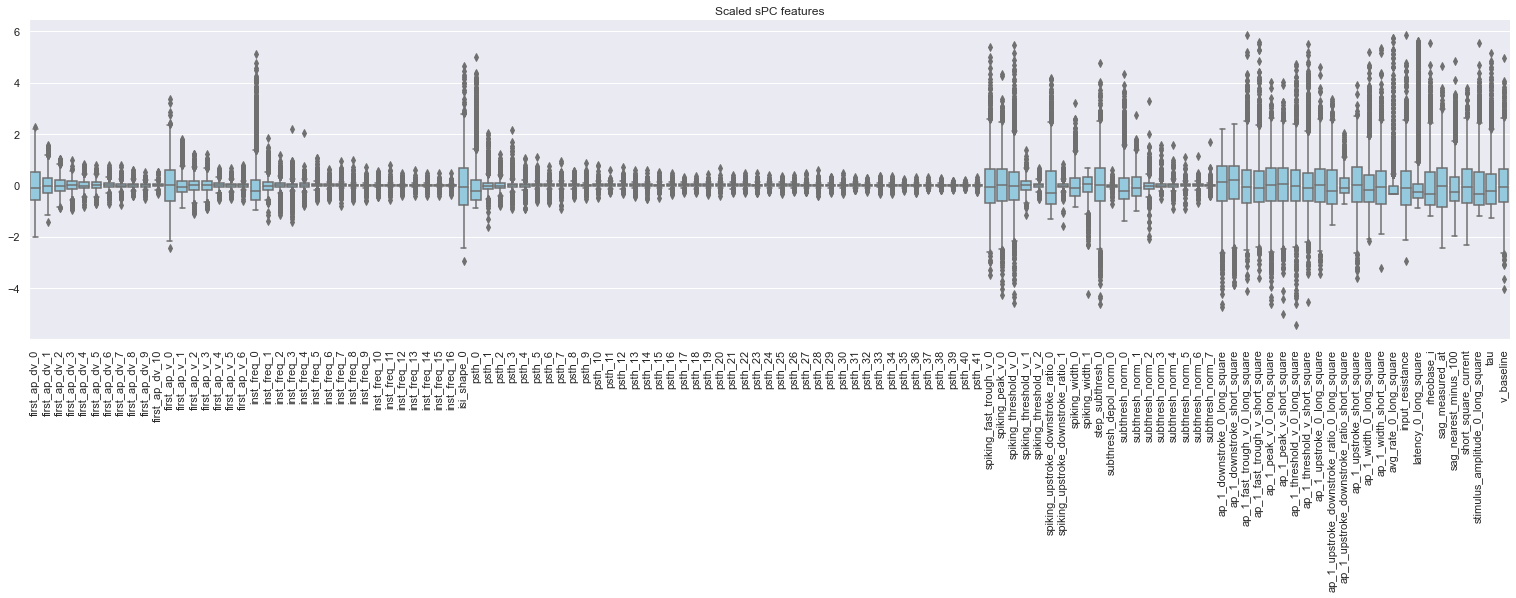

In [86]:
f = df_merged
df = f.melt(value_vars=f[[c for c in f.columns if c != "sample_id"]])
sns.catplot(x="variable", y="value",kind='box', data=df, palette=sns.color_palette(["skyblue"]),aspect=4.4)
ax = plt.gca()
ax.set(**{'title':'Scaled sPC features','xlabel':'','ylabel':''})
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()